# LGBM with pycaret



In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime

# 데이터 가져오기

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
output_dir = '/opt/ml/p4-dkt-feedgate/lgbm_output/서일님'

train_path = os.path.join(data_dir, 'tuning_train_data_bm.csv')
test_path = os.path.join(data_dir, 'tuning_test_data_bm.csv')
# submission_path = os.path.join(output_dir, 'submission.csv')

In [3]:
df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

answerCode2bool = {'userID':object,  'answerCode': 'int16', 'KnowledgeTag':object}
df_train_ori = df_train_ori.astype(answerCode2bool)
df_test_ori = df_test_ori.astype(answerCode2bool)
df_train_ori.Timestamp = pd.to_datetime(df_train_ori.Timestamp)
df_test_ori.Timestamp = pd.to_datetime(df_test_ori.Timestamp)

# EDA & Feature Engineering

In [4]:
df_train_ori.head(2)

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,user_test_correct_cnt,user_acc,isTest,isPostponed,postpone_mean,postpone_sum,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,6,0,0,0.0,0.0,0,0,0.004,1,1585009031,3.0,13.660,0.0,0.0,3.0,0.0,0,1,163,162.0,0.993865,0.984,246,9,978,945.0,0.966258,0.952667,1429,365,356.0,0.975342,0.957333,718,0,0.0,0.0,0,0.6,0.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,6,0,1,1.0,1.0,0,0,0.000,0,1585009034,8.0,26.112,3.0,3.0,11.0,0.0,0,1,163,159.0,0.975460,0.968,242,9,979,946.0,0.966292,0.952667,1429,1743,1587.0,0.910499,0.917067,3439,1,1.0,1.0,10,0.6,0.8,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0


In [5]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test_ori.loc[df_test_ori.answerCode == -1, 'assessmentItemID'].values)

In [6]:
def feature_engineering(df):
    
    # 카테고리형 feature들
    cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','Category','Number','hour','weekday', 
                    'prob_mean_cate','average_user_correct_cate','moving_average_user_correct_10','moving_average_user_correct_5','past_user_prob_count']
    
    for i in enumerate (cat_features) : 
        ca = i[1] 
        df[ca] = df[ca].astype('category') 

    return df

In [7]:
df_test = feature_engineering(df_test_ori)
df = feature_engineering(df_train_ori)
# 피처를 대충만들어서 꽤 오래걸립니다.

In [8]:
df.dtypes

Unnamed: 0                                 int64
userID                                  category
assessmentItemID                        category
testId                                  category
answerCode                                 int16
Timestamp                         datetime64[ns]
KnowledgeTag                            category
Category                                category
Number                                  category
item                                       int64
item_order                                 int64
test_size                                  int64
retest                                     int64
user_test_ans_cnt                          int64
user_test_correct_cnt                    float64
user_acc                                 float64
isTest                                     int64
isPostponed                                int64
postpone_mean                            float64
postpone_sum                               int64
Time                

In [9]:
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)]

## 엔지니어링 이후의 EDA

In [10]:
for i in range(14):
    order = df.loc[(df.item_order == df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    deorder = df.loc[(df.item_order != df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    print(order,deorder)

# 섞어서 풀면 인간의 성능이 항상 떨어진다고 생각했는데, 마지막 2놈은 아니었다.
# 그 와중에 뒤로 갈 수록 정답률 떨어지는건 신기하네

0.6624658036224673 0.5182486920262774
0.6439186285734882 0.5084225999391748
0.6232205172483117 0.4963426269479487
0.5989661078645218 0.48234143387789796
0.5637783249433571 0.4696193708709619
0.5268748949834774 0.4559906770157655
0.494829097283085 0.4438200261548793
0.4619607360452951 0.4351367459108668
0.48256888103462126 0.4208881945994198
0.4796472880139444 0.3949232585596222
0.4258128078817734 0.3718446601941748
0.34984789222077356 0.37168141592920356
0.20306513409961685 0.25
nan nan


In [11]:
# 시험지를 여러번 푼 경우
# 이 친구 보면 알겠지만, 나중에 푼다고 잘 푸는건 아님
# 어짜피 2번째 푸는거면 직전 문제들도 어련히 잘 풀었겠지
df[(df.userID == 1069)  & (df.testId =='A080000127')] 

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,user_test_correct_cnt,user_acc,isTest,isPostponed,postpone_mean,postpone_sum,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
740661,740661,1069,A080127001,A080000127,1,2020-12-02 20:40:36,2719,8,A127001,0,0,8,0,0,0.0,0.000000,0,0,0.0300,12,1606941636,50.0,64.400000,45526.0,54.850602,50.0,62.666667,20,2,228,142.0,0.622807,0.557500,223,5,1824,949.0,0.520285,0.479987,1535,2188,1178.0,0.538391,0.506929,1646,830,430.0,0.518072,5,0.9,0.8,0,0.0,0.0,0,0.0,0.000000,4,1.0,0.250000
740662,740662,1069,A080127002,A080000127,1,2020-12-02 20:41:26,2719,8,A127002,1,1,8,0,1,1.0,1.000000,0,0,0.0325,13,1606941686,146.0,63.127500,45576.0,54.844765,196.0,64.000000,20,2,228,115.0,0.504386,0.482500,193,4,1825,950.0,0.520548,0.479987,1535,2189,1179.0,0.538602,0.506929,1646,831,431.0,0.518652,5,0.9,0.8,0,0.0,0.0,1,1.0,1.000000,5,2.0,0.400000
740663,740663,1069,A080127003,A080000127,1,2020-12-02 20:43:52,2719,8,A127003,2,2,8,0,2,2.0,1.000000,0,0,0.0450,18,1606941832,44.0,40.707500,45722.0,54.954327,240.0,338.333333,20,2,228,134.0,0.587719,0.537500,215,5,1826,951.0,0.520811,0.479987,1535,2190,1180.0,0.538813,0.506929,1646,832,432.0,0.519231,5,0.4,0.4,0,0.0,0.0,2,2.0,1.000000,6,3.0,0.500000
740664,740664,1069,A080127004,A080000127,1,2020-12-02 20:44:36,2721,8,A127004,3,3,8,0,3,3.0,1.000000,0,0,0.0525,21,1606941876,40.0,41.340000,45766.0,54.941176,280.0,328.000000,20,2,228,100.0,0.438596,0.400000,160,4,1829,954.0,0.521597,0.479987,1535,2124,1022.0,0.481168,0.468594,1686,833,433.0,0.519808,5,0.6,0.6,0,0.0,0.0,3,3.0,1.000000,0,0.0,0.000000
740665,740665,1069,A080127005,A080000127,1,2020-12-02 20:45:16,2719,8,A127005,4,4,8,0,4,4.0,1.000000,0,0,0.0475,19,1606941916,47.0,24.172500,45806.0,54.923261,327.0,326.333333,20,2,228,122.0,0.535088,0.477500,191,4,1830,955.0,0.521858,0.479987,1535,2193,1183.0,0.539444,0.506929,1646,834,434.0,0.520384,5,0.6,0.8,0,0.0,0.0,4,4.0,1.000000,7,4.0,0.571429
740666,740666,1069,A080127006,A080000127,1,2020-12-02 20:46:03,2721,8,A127006,5,5,8,0,5,5.0,1.000000,0,0,0.0500,20,1606941963,95.0,59.310000,45853.0,54.913772,422.0,25.333333,20,2,228,132.0,0.578947,0.555000,222,5,1832,957.0,0.522380,0.479987,1535,2125,1023.0,0.481412,0.468594,1686,835,435.0,0.520958,5,0.7,1.0,0,0.0,0.0,5,5.0,1.000000,1,1.0,1.000000
740667,740667,1069,A080127007,A080000127,1,2020-12-02 20:47:38,2711,8,A127007,6,6,8,0,6,6.0,1.000000,0,0,0.0550,22,1606942058,72.0,39.627500,45948.0,54.961722,494.0,29.333333,20,2,229,115.0,0.502183,0.457500,183,4,1842,961.0,0.521716,0.479987,1535,2700,1205.0,0.446296,0.440656,1344,836,436.0,0.521531,5,0.5,0.8,0,0.0,0.0,6,6.0,1.000000,11,2.0,0.181818
740668,740668,1069,A080127008,A080000127,1,2020-12-02 20:48:50,2721,8,A127008,7,7,8,0,7,7.0,1.000000,0,0,0.0000,0,1606942130,18.5,97.721106,46020.0,54.982079,512.5,81.666667,20,2,229,89.0,0.388646,0.371859,148,3,1845,964.0,0.522493,0.479987,1535,2131,1027.0,0.481933,0.468594,1686,837,437.0,0.522103,5,0.7,0.6,0,0.0,0.0,7,7.0,1.000000,2,2.0,1.000000
740701,740701,1069,A080127001,A080000127,1,2020-12-12 05:37:12,2719,8,A127001,0,0,8,1,0,0.0,0.000000,0,0,0.0300,12,1607751432,16.0,64.400000,48114.5,55.304023,528.5,37.000000,5,5,323,185.0,0.572755,0.557500,223,5,2584,1262.0,0.488390,0.479987,1535,2769,1434.0,0.5178

#train/vali 데이터 셋 분리

In [12]:
def my_train_vali_split(df, filter_option = None, train_must_exist_leaderboard = False, ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집
    vali_full = df[(df['userID'] != df['userID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))].copy()
    
    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    
    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

# LGBM 실험 함수

In [13]:
def exam(datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features, 
                     log_experiment=True, experiment_name='lgbm', log_plots=True, log_profile=True, log_data=True)
    
#     # 15개 모델 중 가장 성능 좋은 3개 저장
#     best_3 = compare_models(sort = 'AUC', n_select = 3)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)

#     predict_model(lgbm)
#     predict_model(tuned_lgbm)
    predict_model(final_lgbm)

    log = []
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    print(prediction)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    return final_lgbm, log

# 모델 학습

In [14]:
filter_option = '시험지마지막응답' # 시험지마지막응답, 사용자마지막응답, None
train_must_exist_leaderboard = False # True, False

# FEATS = ['user_acc','prob_mean','test_mean','answerCode']
FEATS = ['user_acc','prob_mean', 'test_mean', 'answerCode']
FEATS += ['tag_mean', 'Time', 'user_test_time_sum', 'user_time_sum', 'postpone_mean']

In [15]:
df.columns # FEATS 참고용

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'Category', 'Number', 'item', 'item_order',
       'test_size', 'retest', 'user_test_ans_cnt', 'user_test_correct_cnt',
       'user_acc', 'isTest', 'isPostponed', 'postpone_mean', 'postpone_sum',
       'Time', 'elapsed_time', 'prob_mean_time', 'user_time_sum',
       'user_time_mean', 'user_test_time_sum', 'moving_average_time', 'hour',
       'weekday', 'past_prob_count', 'past_prob_correct',
       'average_prob_correct', 'prob_mean', 'prob_sum', 'prob_mean_cate',
       'past_test_count', 'past_test_correct', 'average_test_correct',
       'test_mean', 'test_sum', 'past_tag_count', 'past_tag_correct',
       'average_tag_correct', 'tag_mean', 'tag_sum', 'past_user_count',
       'past_user_correct', 'average_user_correct',
       'average_user_correct_cate', 'moving_average_user_correct_10',
       'moving_average_user_correct_5', 'past_user_prob_count',
       'past_user

In [16]:
datasets = my_train_vali_split(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, ratio = 1.0) # 어떤 시드를 주던 영향 안받음.

print(len(datasets[0]), len(datasets[4]))
print(datasets[0].answerCode.mean(), datasets[4].answerCode.mean())

374594 4366
0.5601958386946935 0.48259276225377923


In [17]:
model,log = exam(datasets ,FEATS)

print('\n', model)
print('\n'.join(log))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7500,0.8199,0.8159,0.7567,0.7852,0.4872,0.4892
1,0.7568,0.8234,0.8244,0.7612,0.7915,0.5008,0.5031
2,0.7499,0.8190,0.8142,0.7575,0.7848,0.4873,0.4891
3,0.7521,0.8227,0.8154,0.7596,0.7865,0.4919,0.4936
4,0.7523,0.8253,0.8133,0.7609,0.7862,0.4925,0.4941
5,0.7535,0.8215,0.8150,0.7615,0.7874,0.4949,0.4965
6,0.7510,0.8192,0.8127,0.7595,0.7852,0.4898,0.4914
7,0.7512,0.8208,0.8125,0.7599,0.7853,0.4904,0.4919
8,0.7522,0.8196,0.8148,0.7600,0.7865,0.4921,0.4938
9,0.7478,0.8184,0.8093,0.7571,0.7824,0.4833,0.4848


Finished loading model, total used 190 iterations
Finished loading model, total used 190 iterations
Finished loading model, total used 190 iterations


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7571,0.8297,0.8186,0.7647,0.7907,0.5020,0.5036


         user_acc  prob_mean  test_mean  answerCode  tag_mean        Time  \
744      0.600000   0.150376   0.358514           0  0.299311  1608694819   
1677     0.800000   0.478261   0.439189           1  0.449324  1605235640   
2786     0.285714   0.562249   0.494461           1  0.472489  1607726908   
6292     0.750000   0.508361   0.537025           1  0.538045  1603450870   
6897     0.500000   0.496644   0.782377           0  0.721469  1603692066   
...           ...        ...        ...         ...       ...         ...   
2266499  0.250000   0.682274   0.590394           1  0.605469  1598529304   
2266514  0.500000   0.787149   0.690953           1  0.717230  1603452257   
2266561  0.750000   0.558528   0.774516           1  0.719527  1603103309   
2266576  0.250000   0.575758   0.731463           0  0.744312  1603269200   
2266585  1.000000   0.545151   0.653878           1  0.700029  1597972129   

         user_test_time_sum  user_time_sum  postpone_mean  Label  Score_0  

In [18]:
# plot_model(estimator = model, plot = 'learning')

In [19]:
# plot_model(estimator = model, plot = 'confusion_matrix')

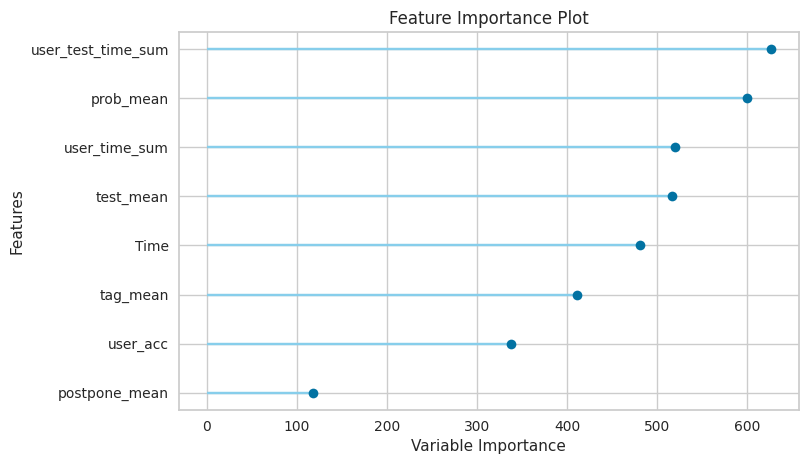

In [20]:
plot_model(estimator = model, plot = 'feature')



# Inference

In [21]:
# MAKE PREDICTION
# SAVE OUTPUT

prediction = predict_model(model, data=df_test_shift[FEATS], raw_score=True)
total_preds = prediction.Score_1.values

prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

name = ('filter_option', 'train_must_exist_leaderboard', 'FEATS', 'log')
logs = (filter_option, train_must_exist_leaderboard, FEATS,log)
write_path = os.path.join(output_dir, f"{prediction_name}_log.txt")
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    for n, l in zip(name, logs):
        w.write(f'{n}: {l}\n')

writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0613_1948.csv
writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0613_1948_log.txt
